
=== SEED 1 ===

--- Running PCA+GLS, seed=1 ---

--- Running PCA+TABU, seed=1 ---

--- Running PCI+GLS, seed=1 ---

--- Running PCI+TABU, seed=1 ---

--- Running SAV+GLS, seed=1 ---
No solution found!

--- Running SAV+TABU, seed=1 ---
No solution found!

=== SEED 2 ===

--- Running PCA+GLS, seed=2 ---
No solution found!

--- Running PCA+TABU, seed=2 ---
No solution found!

--- Running PCI+GLS, seed=2 ---
No solution found!

--- Running PCI+TABU, seed=2 ---
No solution found!

--- Running SAV+GLS, seed=2 ---
No solution found!

--- Running SAV+TABU, seed=2 ---
No solution found!

=== SEED 3 ===

--- Running PCA+GLS, seed=3 ---

--- Running PCA+TABU, seed=3 ---

--- Running PCI+GLS, seed=3 ---

--- Running PCI+TABU, seed=3 ---

--- Running SAV+GLS, seed=3 ---
No solution found!

--- Running SAV+TABU, seed=3 ---
No solution found!

=== SEED 4 ===

--- Running PCA+GLS, seed=4 ---
No solution found!

--- Running PCA+TABU, seed=4 ---
No solution found!

--- Running PCI+GLS, seed=4 ---
No so

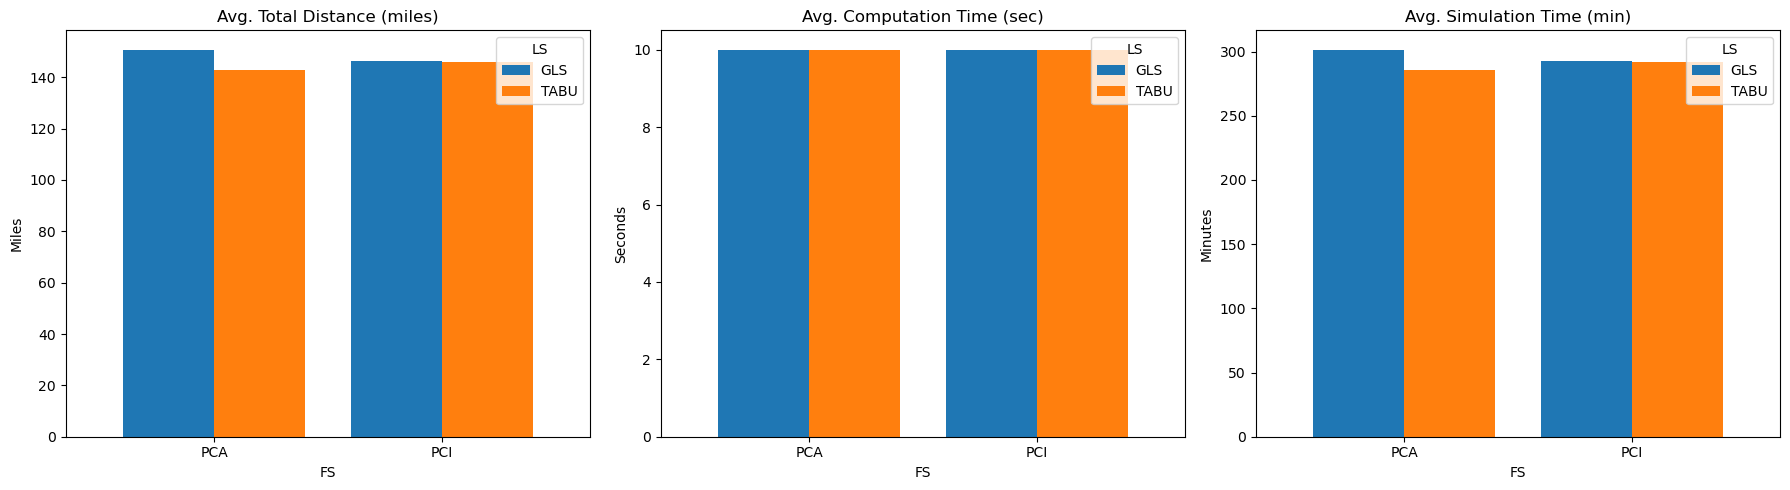

Grouped bar chart (averages across seeds) saved to grouped_comparison_across_seeds.png


In [3]:
import time
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

# -----------------------------------
# CONFIGURATION
# -----------------------------------
NUM_REQUESTS = 30         # Number of requests (each = one pickup and one dropoff)
NUM_VEHICLES = 3          # Number of vehicles available
TIME_LIMIT_SEC = 10       # Solver time limit in seconds
RANDOM_SEEDS = [1, 2, 3, 4, 5]  # List of seeds for multiple runs
ENABLE_DISJUNCTIONS = True     # Allow skipping requests with a penalty
DISJUNCTION_PENALTY = 30000      # Penalty for skipping a pickup (scaled units)

def create_rural_data(num_requests=8, num_vehicles=3, seed=42):
    """
    Generates a 'rural' dial-a-ride problem using a single time window per request.
    
    Each request is generated with:
      - A random earliest pickup time between 7:00 AM (420) and 3:00 PM (900) minutes.
      - A random latest dropoff time between (earliest + 30) minutes and 8:00 PM (1200) minutes.
      
    Both the pickup and dropoff nodes for a request are assigned the same time window.
    The pickup–delivery constraint ensures that the pickup occurs before the dropoff.
    
    The geographic area is set to ±0.1° around Lake City, FL.
    """
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = 0.1
    lon_range = 0.1

    # Depot at center
    locations = [("Depot", center_lat, center_lon)]
    
    random.seed(seed)
    requests = []
    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)
        
        # Earliest pickup: between 7:00 AM (420) and 3:00 PM (900)
        earliest = random.randint(420, 900)
        # Latest dropoff: at least 30 minutes later, up to 8:00 PM (1200)
        latest = random.randint(earliest + 30, 1200)
        
        requests.append({
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": (earliest, latest)
        })
    
    # Build location list: depot first, then pickup and dropoff nodes for each request.
    for req in requests:
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    data["vehicle_capacities"] = [12] * num_vehicles  # Increased capacity
    
    import numpy as np
    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    time_mat = (dist_mat / 30.0) * 60.0  # Assuming average speed 30 mph => minutes
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window: full day [0, 1440]
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2 * i
        do_idx = 1 + 2 * i + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        # Both nodes get the same time window [earliest, latest]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    return data, locations, passenger_node_to_name

def solve_routing(data, locations, passenger_node_to_name,
                  fs_strategy, ls_heuristic, time_limit=60,
                  enable_disjunctions=False, penalty=30000):
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    # Distance callback
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    # Demand / Capacity
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    # Time dimension
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30_000, 24 * 60 * 60 * 1000,
                         False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    # Set time windows for each node
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0] * 60_000, tw[1] * 60_000)
    
    # Pickup and delivery constraints
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Optionally allow skipping requests with a penalty
    if enable_disjunctions:
        for (pu_idx, do_idx) in data["pickups_deliveries"]:
            pu_index = manager.NodeToIndex(pu_idx)
            routing.AddDisjunction([pu_index], penalty)
    
    fs_map = {
        "PCA": routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC,
        "PCI": routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
        "SAV": routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    }
    ls_map = {
        "GLS": routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
        "TABU": routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
    }
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = fs_map[fs_strategy]
    search_params.local_search_metaheuristic = ls_map[ls_heuristic]
    search_params.time_limit.FromSeconds(time_limit)
    
    # Enable logs for debugging
    search_params.log_search = True
    
    start_time = time.time()
    solution = routing.SolveWithParameters(search_params)
    comp_time = time.time() - start_time
    
    if not solution:
        print("No solution found!")
        return None, None
    
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            node_idx = manager.IndexToNode(index)
            route_nodes.append(node_idx)
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    return {
        "distance_miles": total_dist_miles,
        "comp_time_sec": comp_time,
        "sim_time_min": sim_time_min
    }, routes

def visualize_routes(routes, data, locations, passenger_node_to_name, map_filename):
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)
    
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except:
        G = None
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']
    node_ids = []
    if G:
        for loc in locations:
            lat, lon = loc[1], loc[2]
            try:
                node = ox.distance.nearest_nodes(G, lon, lat)
                node_ids.append(node)
            except:
                node_ids.append(None)
    else:
        node_ids = [None] * len(locations)
    
    for v_idx, route in enumerate(routes):
        color = colors[v_idx % len(colors)]
        path = []
        valid = True
        for i in range(len(route) - 1):
            if not G:
                path.append(route[i])
            else:
                o_node = node_ids[route[i]]
                d_node = node_ids[route[i + 1]]
                if o_node is None or d_node is None:
                    valid = False
                    break
                try:
                    seg = nx.shortest_path(G, o_node, d_node, weight='length')
                    path.extend(seg)
                except nx.NetworkXNoPath:
                    valid = False
                    break
        if not valid or not path:
            continue
        
        if G:
            coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        else:
            coords = [(locations[i][1], locations[i][2]) for i in route]
        
        folium.PolyLine(coords, color=color, weight=2.5).add_to(m)
        
        for node_idx in route:
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                name = passenger_node_to_name.get(node_idx, "Pickup")
                folium.Marker((lat, lon), icon=folium.Icon(color=color, icon='plus'),
                              popup=f'Pickup: {name}').add_to(m)
            elif dem == -1:
                name = passenger_node_to_name.get(node_idx, "Dropoff")
                folium.Marker((lat, lon), icon=folium.Icon(color=color, icon='minus'),
                              popup=f'Dropoff: {name}').add_to(m)
            else:
                folium.Marker((lat, lon), icon=folium.Icon(color='black', icon='home'),
                              popup='Depot').add_to(m)
    
    m.save(map_filename)
    print(f"Map saved to {map_filename}")
    if IN_JUPYTER:
        display(m)

def main():
    """
    This function:
      1. Runs the scenario across multiple random seeds.
      2. For each seed, tests three first-solution strategies (PCA, PCI, SAV)
         combined with two local search methods (GLS, TABU).
      3. Aggregates results across all seeds and displays a grouped bar chart.
    """
    fs_list = ["PCA", "PCI", "SAV"]
    ls_list = ["GLS", "TABU"]
    
    all_runs = []
    for seed in RANDOM_SEEDS:
        print(f"\n=== SEED {seed} ===")
        data, locations, passenger_node_to_name = create_rural_data(
            num_requests=NUM_REQUESTS,
            num_vehicles=NUM_VEHICLES,
            seed=seed
        )
        
        for fs in fs_list:
            for ls in ls_list:
                label = f"{fs}+{ls}"
                print(f"\n--- Running {label}, seed={seed} ---")
                metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                                fs, ls,
                                                time_limit=TIME_LIMIT_SEC,
                                                enable_disjunctions=ENABLE_DISJUNCTIONS,
                                                penalty=DISJUNCTION_PENALTY)
                if metrics is None:
                    continue
                all_runs.append({
                    "Seed": seed,
                    "FS": fs,
                    "LS": ls,
                    "TotalDist": metrics["distance_miles"],
                    "CompTime": metrics["comp_time_sec"],
                    "SimTime": metrics["sim_time_min"]
                })
                # Uncomment below to visualize individual routes:
                # ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                # mapfile = f"routes_{label}_seed{seed}_{ts}.html"
                # visualize_routes(routes, data, locations, passenger_node_to_name, mapfile)
    
    df = pd.DataFrame(all_runs)
    if df.empty:
        print("\nNo solutions found for any combination across all seeds!")
        return
    
    print("\n--- Raw Results (All Seeds) ---")
    print(df)
    
    grouped = df.groupby(["FS", "LS"]).agg({
        "TotalDist": "mean",
        "CompTime": "mean",
        "SimTime": "mean"
    }).reset_index()
    
    print("\n--- Averages Across All Seeds ---")
    print(grouped)
    
    # Grouped bar charts: one subplot per metric, with FS on x-axis and LS as groups
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    pivot_dist = grouped.pivot(index="FS", columns="LS", values="TotalDist")
    pivot_comp = grouped.pivot(index="FS", columns="LS", values="CompTime")
    pivot_sim = grouped.pivot(index="FS", columns="LS", values="SimTime")
    
    pivot_dist.plot(kind="bar", ax=axes[0], rot=0, width=0.8)
    axes[0].set_title("Avg. Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    pivot_comp.plot(kind="bar", ax=axes[1], rot=0, width=0.8)
    axes[1].set_title("Avg. Computation Time (sec)")
    axes[1].set_ylabel("Seconds")
    
    pivot_sim.plot(kind="bar", ax=axes[2], rot=0, width=0.8)
    axes[2].set_title("Avg. Simulation Time (min)")
    axes[2].set_ylabel("Minutes")
    
    plt.tight_layout()
    plt.savefig("grouped_comparison_across_seeds.png")
    plt.show()
    print("Grouped bar chart (averages across seeds) saved to grouped_comparison_across_seeds.png")

if __name__ == "__main__":
    main()
